# Prédiction de température en utilisant des méthodes d'intelligence artificielle

Nous avons trouvé une base de données sur opendatasoft :

Ce sont des données issues des messages internationaux d’observation en surface (SYNOP) circulant sur le système mondial de télécommunication (SMT) de l’Organisation Météorologique Mondiale (OMM). Les paramètres atmosphériques sont mesurés (température, humidité, direction et force du vent, pression atmosphérique, hauteur de précipitations) ou observés (temps sensible, description des nuages, visibilité) depuis la surface terrestre. Selon l'instrumentation et les spécificités locales, d'autres paramètres peuvent être disponibles (hauteur de neige, état du sol, etc.)

Elle est actualisée chaque jour.

Notre but avec cette base de données est de faire du forecasting des températures pour prédire d'éventuelles sécheresses par exemple. Pour renforcer ensuite ces mesures, nous réaliserons d'autres prédictions pour confirmer ou infirmer notre conclusion.

Pour réaliser cela nous allons utiliser les différentes méthodes vues en cours tel que : 
- exponential smoothing
- les differends modèles SARIMAX
- du deep learning avec un model RNN

Cela nous permettra de les comparer et de séléctionner ce qui nous semble etre le modèle plus pertinent, en plus d'observer leurs différences.

Certains modèles utiliseront les features présentes dans la base de données et d'autre uniquement les valeurs des températures. 

In [911]:
# Basic import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Import de la database

Les deux cellules suivantes sont utiles pour importer la database. Cette database étant trop grosse pour aller sur github nous avons décidé de la télécharger une seul fois et de ne pas la push sur notre repository github.

Pour la télécharger il suffit de décommenter les deux cellules suivantes, de les compiler (cela peut être un peu long), et de les recommenter.

In [912]:
# import wget

# site_url = 'https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/download/?format=csv&q=date:%5B2018-12-31T23:00:00Z+TO+2022-10-01T21:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
# file_name = wget.download(site_url)



In [913]:
#!mv donnees-synop-essentielles-omm.csv data_meteo.csv

## Travail sur la database

In [914]:
df = pd.read_csv('data_meteo.csv',sep=';')
df.head()

,ID OMM station,Date,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,7558,2019-11-09T13:00:00+01:00,101380.0,-110.0,8.0,320.0,4.9,278.05,274.35,77.0,...,712,Millau,12145,CC de Millau Grands Causses,241200567.0,Aveyron,12,Occitanie,76.0,11
1,7790,2019-11-09T13:00:00+01:00,100790.0,-60.0,8.0,30.0,3.5,288.55,281.95,65.0,...,10,Lucciana,2B148,CC de Marana-Golo,200036499.0,Haute-Corse,2B,Corse,94.0,11
2,61980,2019-11-09T13:00:00+01:00,101570.0,-130.0,6.0,80.0,4.4,299.65,290.45,57.0,...,8,Sainte-Marie,97418,CA Intercommunale du Nord de la Réunion (CINOR),249740119.0,La Réunion,974,La Réunion,4.0,11
3,61980,2019-11-09T16:00:00+01:00,101710.0,140.0,3.0,90.0,2.8,297.65,290.65,65.0,...,8,Sainte-Marie,97418,CA Intercommunale du Nord de la Réunion (CINOR),249740119.0,La Réunion,974,La Réunion,4.0,11
4,81401,2019-11-09T16:00:00+01:00,101020.0,80.0,8.0,50.0,2.6,306.55,297.75,60.0,...,5,Saint-Laurent-du-Maroni,97311,CC de l'Ouest Guyanais,249730037.0,Guyane,973,Guyane,3.0,11


In [915]:
df.shape

(648685, 82)

### Transformations nécessaires 

On transforme la date en string pour pouvoir la manipuler à notre souhait.

Plus tard dans ce notebook on utilisera plutôt l'index qui numérote les lignes dans un ordre croissant plutôt que la data par soucis d'habitude et pour gagner du temps car réecrire la date en permanence avec les heures est fastidieux.

In [916]:
df['Date'] = df['Date'].astype('string')

In [917]:
for i in range(df.shape[0]):
    df['Date'][i]=df['Date'][i][0:10]+" "+df['Date'][i][11:19]


In [918]:
df['Date']=pd.to_datetime(df['Date'])


On sélectionne les colonnes qui nous interessent. 
On aurait pu procéder à une étude plus approfondie des différentes features en regardant des graphes de corrélation ect ... cependant nous manquions de temps car installer certaines library comme Tensorflow sur un mac avec une puce M1 a pris beaucoup de temps. Nous avons donc simplement fais quelque recherche sur internet.

In [919]:
columns = ['Date','region (name)','Température (°C)','Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

In [920]:
df_Date= df[columns]
df_Date.head()

,Date,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2019-11-09 13:00:00,Occitanie,4.9,101380.0,4.9,77.0,92970.0,8.1,-0.1
1,2019-11-09 13:00:00,Corse,15.4,100790.0,3.5,65.0,100650.0,5.5,0.0
2,2019-11-09 13:00:00,La Réunion,26.5,101570.0,4.4,57.0,101420.0,6.0,0.0
3,2019-11-09 16:00:00,La Réunion,24.5,101710.0,2.8,65.0,101560.0,4.8,0.0
4,2019-11-09 16:00:00,Guyane,33.4,101020.0,2.6,60.0,100960.0,NaN,0.0


In [921]:
df_Date = df_Date.dropna()
df_Date.shape

(473732, 9)

In [922]:
df_Date.set_index('Date', inplace = True)
df_Date.head()

,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,,
2019-11-09 13:00:00,Occitanie,4.9,101380.0,4.9,77.0,92970.0,8.1,-0.1
2019-11-09 13:00:00,Corse,15.4,100790.0,3.5,65.0,100650.0,5.5,0.0
2019-11-09 13:00:00,La Réunion,26.5,101570.0,4.4,57.0,101420.0,6.0,0.0
2019-11-09 16:00:00,La Réunion,24.5,101710.0,2.8,65.0,101560.0,4.8,0.0
2019-11-09 19:00:00,Normandie,6.7,100280.0,4.0,96.0,99470.0,6.3,8.9


### Création d'une première database avec une information par date par colonne

Dans cette database on regroupe les informations par la date ce qui a pour effet de supprimer toute information géographique. Avec cette base de données on peut travailler sur l'allure globale de la température en France. Ce n'est pas le but principal de notre projet mais cela peut être intéréssant. Nous avons regroupé les données en faisant une moyenne.

In [923]:
df_Date = df_Date.groupby(by=['Date']).mean()

df_Date.head()

,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
Date,,,,,,,
2019-01-01 01:00:00,7.738636,103197.272727,2.679545,85.681818,101559.318182,5.129545,-0.004545
2019-01-01 04:00:00,6.943182,103215.227273,3.020455,85.863636,101567.272727,5.293182,-0.004545
2019-01-01 07:00:00,6.700000,103189.767442,2.883721,86.813953,101510.000000,5.172093,-0.009302
2019-01-01 10:00:00,7.568182,103253.409091,2.627273,84.704545,101605.454545,4.959091,0.011364
2019-01-01 13:00:00,9.095349,103211.162791,3.123256,80.139535,101542.558140,5.753488,-0.004651


In [924]:
df_Date.shape

(10954, 7)

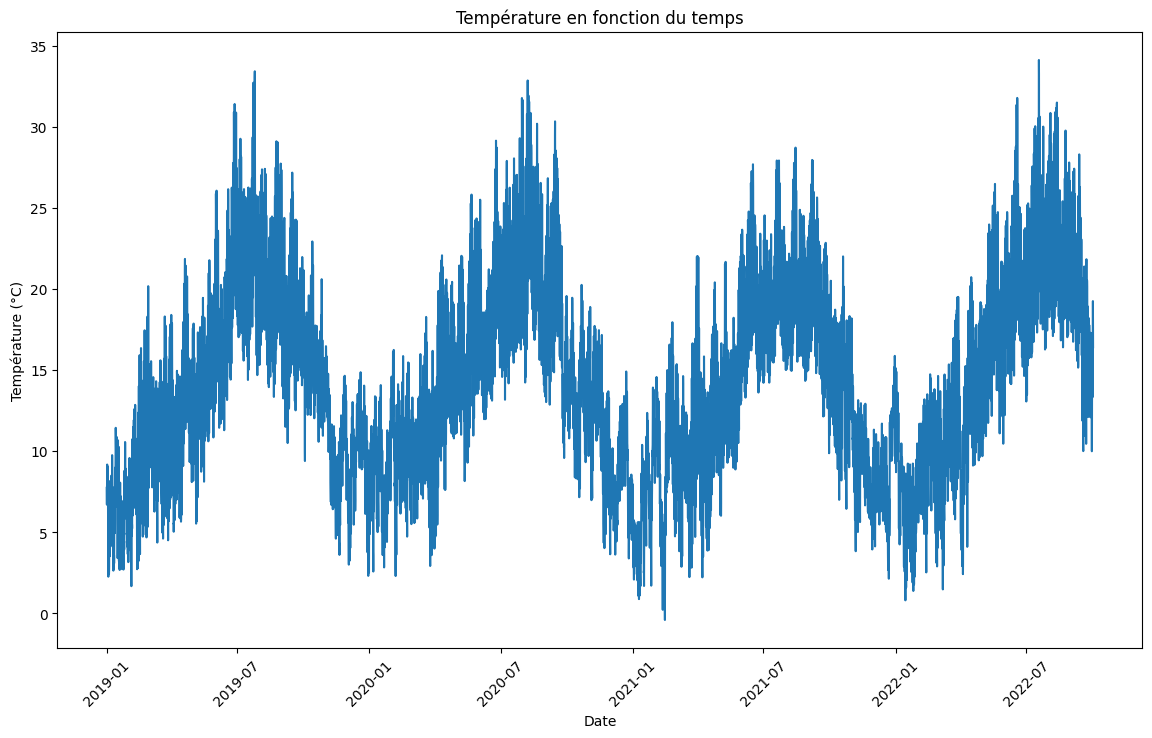

In [925]:
plt.figure(figsize=(14,8))
plt.plot(df_Date.index,df_Date['Température (°C)'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction du temps')
plt.show()

On peut observer par exemple sur ce graphique l'alternance entre les saisons chaudes et froides en France avec des températures qui oscillent assez clairement. 

### Création d'une seconde database avec une information par date en fonction de la région par colonne

On groupe donc les features en fonction de la date et de la région pour pouvoir étudier le comportement de la température sur une région en particulier.

In [926]:
df_region = df[columns]
df_region = df_region.dropna()

In [927]:
df_region = df_region.groupby(by=['Date','region (name)']).mean()
df_region.head()

Température (°C)  \
Date                region (name)                               
2019-01-01 01:00:00 Auvergne-Rhône-Alpes             6.766667   
                    Bourgogne-Franche-Comté          7.100000   
                    Bretagne                         8.450000   
                    Centre-Val de Loire              7.050000   
                    Corse                            6.300000   

                                             Pression au niveau mer  \
Date                region (name)                                     
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                   103330.0   
                    Bourgogne-Franche-Comté                103480.0   
                    Bretagne                               103760.0   
                    Centre-Val de Loire                    103650.0   
                    Corse                                  102690.0   

                                             Vitesse du vent moyen 10 mn  \
Date                region (name)                                          
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                        4.433333   
                    Bourgogne-Franche-Comté                     2.000000   
                    Bretagne                                    1.700000   
                    Centre-Val de Loire                         1.350000   
                    Corse                                       3.000000   

                                             Humidité  Pression station  \
Date                region (name)                                         
2019-01-01 01:00:00 Auvergne-Rhône-Alpes         88.0          100690.0   
                    Bourgogne-Franche-Comté      93.0          100670.0   
                    Bretagne                     82.0          103025.0   
                    Centre-Val de Loire          90.5          101915.0   
                    Corse                        78.0          102560.0   

                                             Rafales sur une période  \
Date                region (name)                                      
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                    8.333333   
                    Bourgogne-Franche-Comté                 3.700000   
                    Bretagne                                3.850000   
                    Centre-Val de Loire                     4.400000   
                    Corse                                   5.200000   

                                             Précipitations dans les 3 dernières heures  
Date                region (name)                                                        
2019-01-01 01:00:00 Auvergne-Rhône-Alpes                                      -0.033333  
                    Bourgogne-Franche-Comté                                    0.000000  
                    Bretagne                                                   0.000000  
                    Centre-Val de Loire                                        0.000000  
                    Corse                                                      0.000000

Dans les deux cellules suivantes on supprime les index ce qui a pour concéquences d'avoir des date redondante puis on crée des dummies avec la colonne région, cela nous permettra de créer une base de données par régions en prenant les lignes ou il y a un 1 pour chaque région correspondante.

In [928]:
df_region = df_region.reset_index(level=['Date','region (name)'])
df_region['region (name)'] = df_region['region (name)'].astype('string')
df_region

,Date,region (name),Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2019-01-01 01:00:00,Auvergne-Rhône-Alpes,6.766667,103330.0,4.433333,88.0,100690.0,8.333333,-0.033333
1,2019-01-01 01:00:00,Bourgogne-Franche-Comté,7.100000,103480.0,2.000000,93.0,100670.0,3.700000,0.000000
2,2019-01-01 01:00:00,Bretagne,8.450000,103760.0,1.700000,82.0,103025.0,3.850000,0.000000
3,2019-01-01 01:00:00,Centre-Val de Loire,7.050000,103650.0,1.350000,90.5,101915.0,4.400000,0.000000
4,2019-01-01 01:00:00,Corse,6.300000,102690.0,3.000000,78.0,102560.0,5.200000,0.000000
...,...,...,...,...,...,...,...,...,...
192730,2022-10-01 23:00:00,Pays de la Loire,17.400000,102200.0,4.500000,96.0,101890.0,10.000000,-0.100000
192731,2022-10-01 23:00:00,Provence-Alpes-Côte d'Azur,18.500000,102165.0,3.400000,78.5,101820.0,5.200000,0.000000
192732,2022-10-01 23:00:00,Saint-Pierre-et-Miquelon,12.200000,101570.0,8.000000,90.0,101490.0,12.300000,0.000000
192733,2022-10-01 23:00:00,Terres australes et antarctiques françaises,-0.300000,101500.0,3.600000,79.0,101120.0,5.700000,0.000000


In [929]:
df_region = pd.get_dummies(df_region,columns=['region (name)'],prefix="",prefix_sep='')
df_region

,Date,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,...,Martinique,Mayotte,Normandie,Nouvelle-Aquitaine,Occitanie,Pays de la Loire,Provence-Alpes-Côte d'Azur,Saint-Pierre-et-Miquelon,Terres australes et antarctiques françaises,Île-de-France
0,2019-01-01 01:00:00,6.766667,103330.0,4.433333,88.0,100690.0,8.333333,-0.033333,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,7.100000,103480.0,2.000000,93.0,100670.0,3.700000,0.000000,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 01:00:00,8.450000,103760.0,1.700000,82.0,103025.0,3.850000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 01:00:00,7.050000,103650.0,1.350000,90.5,101915.0,4.400000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 01:00:00,6.300000,102690.0,3.000000,78.0,102560.0,5.200000,0.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192730,2022-10-01 23:00:00,17.400000,102200.0,4.500000,96.0,101890.0,10.000000,-0.100000,0,0,...,0,0,0,0,0,1,0,0,0,0
192731,2022-10-01 23:00:00,18.500000,102165.0,3.400000,78.5,101820.0,5.200000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
192732,2022-10-01 23:00:00,12.200000,101570.0,8.000000,90.0,101490.0,12.300000,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,0
192733,2022-10-01 23:00:00,-0.300000,101500.0,3.600000,79.0,101120.0,5.700000,0.000000,0,0,...,0,0,0,0,0,0,0,0,1,0


Création de chaque base de données à la main 

In [930]:



columns = ['Date','Température (°C)','Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

AuvergneRhoneAlpes=df_region.loc[df_region[regions[0]]==1].reset_index(drop=True)
AuvergneRhoneAlpes = AuvergneRhoneAlpes[columns]
BourgogneFrancheComte=df_region.loc[df_region[regions[1]]==1].reset_index(drop=True)
BourgogneFrancheComte =BourgogneFrancheComte[columns]
Bretagne = df_region.loc[df_region[regions[2]]==1].reset_index(drop=True)
Bretagne =Bretagne[columns]
CentreValdeLoire= df_region.loc[df_region[regions[3]]==1].reset_index(drop=True)
CentreValdeLoire = CentreValdeLoire[columns]
Corse=df_region.loc[df_region[regions[4]]==1].reset_index(drop=True)
Corse = Corse[columns]
GrandEst=df_region.loc[df_region[regions[5]]==1].reset_index(drop=True)
GrandEst = GrandEst[columns]
Guyane=df_region.loc[df_region[regions[6]]==1].reset_index(drop=True)
Guyane = Guyane[columns]
HautsdeFrance=df_region.loc[df_region[regions[7]]==1].reset_index(drop=True)
HautsdeFrance = HautsdeFrance[columns]
LaReunion=df_region.loc[df_region[regions[8]]==1].reset_index(drop=True)
LaReunion = LaReunion[columns]
Martinique=df_region.loc[df_region[regions[9]]==1].reset_index(drop=True)
Martinique = Martinique[columns]
Mayotte=df_region.loc[df_region[regions[10]]==1].reset_index(drop=True)
Mayotte = Mayotte[columns]
Normandie=df_region.loc[df_region[regions[11]]==1].reset_index(drop=True)
Normandie = Normandie[columns]
NouvelleAquitaine=df_region.loc[df_region[regions[12]]==1].reset_index(drop=True)
NouvelleAquitaine = NouvelleAquitaine[columns]
Occitanie=df_region.loc[df_region[regions[13]]==1].reset_index(drop=True)
Occitanie = Occitanie[columns]
PaysdelaLoire=df_region.loc[df_region[regions[14]]==1].reset_index(drop=True)
PaysdelaLoire = PaysdelaLoire[columns]
ProvenceAlpesCotedAzur=df_region.loc[df_region[regions[15]]==1].reset_index(drop=True)
ProvenceAlpesCotedAzur = ProvenceAlpesCotedAzur[columns]
SaintPierreetMiquelon=df_region.loc[df_region[regions[16]]==1].reset_index(drop=True)
SaintPierreetMiquelon = SaintPierreetMiquelon[columns]
IledeFrance=df_region.loc[df_region[regions[17]]==1].reset_index(drop=True)
IledeFrance = IledeFrance[columns]
Terresaustralesetantarctiquesfrançaises=df_region.loc[df_region[regions[18]]==1].reset_index(drop=True)
Terresaustralesetantarctiquesfrançaises =Terresaustralesetantarctiquesfrançaises[columns]


Il y avait probablement une méthode pour accélérer ce processus. Cepednant ce n'était pas l'objectif principal de notre projet, nous avons donc fait comme nous l'avons imaginé.

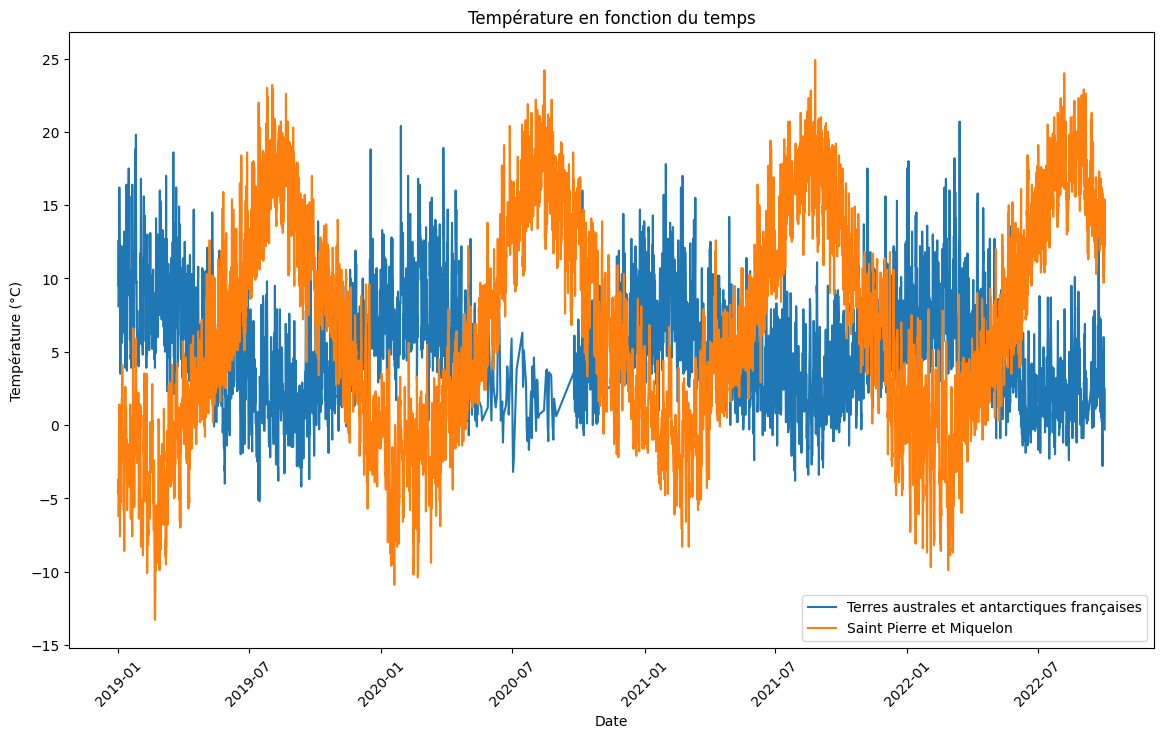

In [931]:
plt.figure(figsize=(14,8))


plt.plot(Terresaustralesetantarctiquesfrançaises['Date'],Terresaustralesetantarctiquesfrançaises['Température (°C)'])
plt.plot(SaintPierreetMiquelon[ 'Date'],SaintPierreetMiquelon['Température (°C)'])



plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.title('Température en fonction du temps')
plt.legend(['Terres australes et antarctiques françaises','Saint Pierre et Miquelon'])
plt.show()



Nous pouvons observer par exemple sur ce graphique ci-dessus que les températures entre les Terres Australes et Antarctiques Francaises et Saint Pierre et Miquelon sont comme décalées. Cela est dû au fait qu'ils ne se situent pas dans le même hémisphère.

### Trouver la saisonnalité

Nous pouvons imaginer une saisonnalité de 1 ans soit 365 * 24 / 3 = 2920 car nous avons un relevé de données toutes les 3 heures.

Vérifions ça.

In [932]:
df_temporaire = pd.DataFrame(df_Date.index.astype('string'))
for year in range (df_temporaire.shape[0]):
    df_temporaire['Date'][year] = df_temporaire['Date'][year][0:4]

df_temporaire['Date'].value_counts()


2020    2926
2019    2918
2021    2918
2022    2192
Name: Date, dtype: Int64

Il y a en moyenne, en comptant que les années complète 2920 mesures ce qui correspond à nos précédents calculs.

On peut aussi imaginer une periodicité journalière. Il y a des observations toutes les trois heures, donc 24 / 3 = 8 on rajoute 1 pour l'obseration qui revient au même point donc 9.

## Etude de la température moyenne des territoires français 

In [933]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

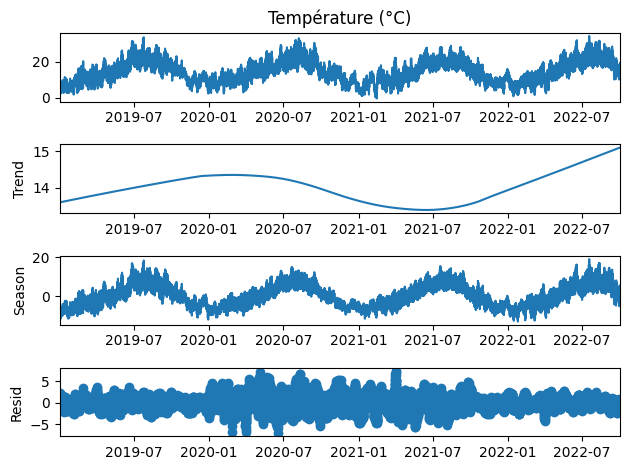

In [934]:
#On choisit une period = à 2920 comme vu précédement
result = STL(df_Date['Température (°C)'], period=2910).fit()

_ = result.plot()

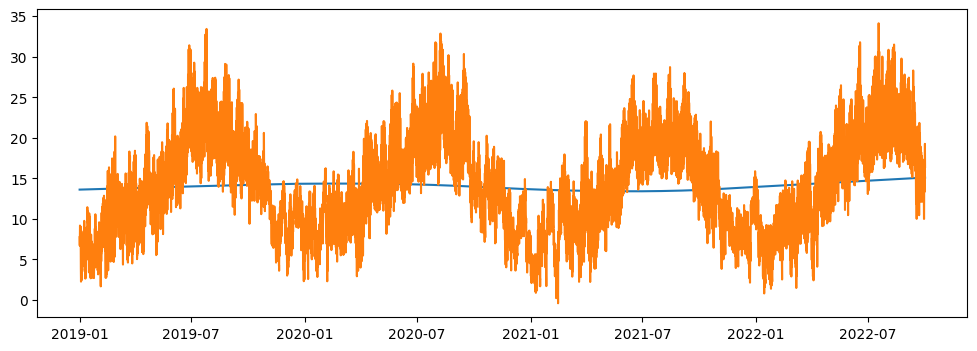

In [935]:
plt.figure(figsize=(12,4))
plt.plot(result.trend)
plt.plot(df_Date['Température (°C)'])

On peut voir que la tendance reste assez constante, on observe pas particulièrement de changements. Si nous avions plus de données du passé, nous verrions probablement une tendance qui augmente au fur et à mesure dû au réchauffement climatique. Nous n'avons probablement pas assez de recul pour le voir.

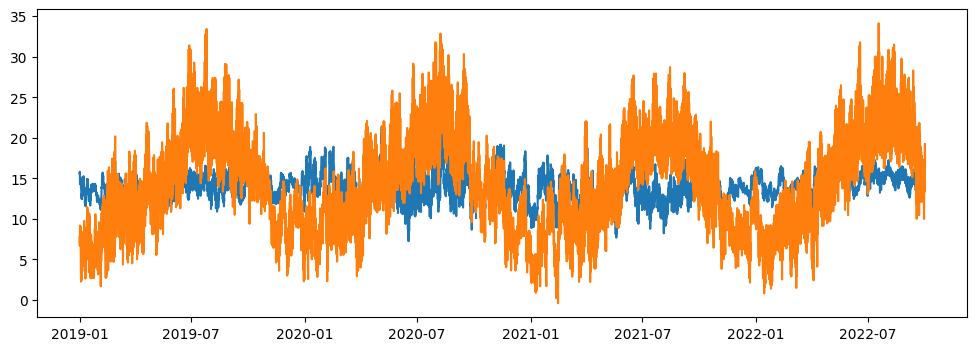

In [936]:
plt.figure(figsize=(12,4))
plt.plot(result.resid+ result.trend)
plt.plot(df_Date['Température (°C)'])

En récupérant la tendance et les résidus, nous observons que la saisonalité annuel a été effacée il ne reste donc plus que la saisonalité journalière.

On peut donc essayer de l'enlever.

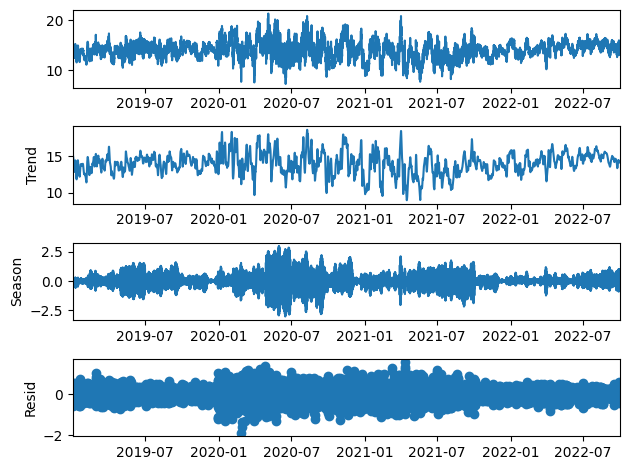

In [937]:

result2 = STL(result.resid+ result.trend, period=8).fit()

_ = result2.plot()

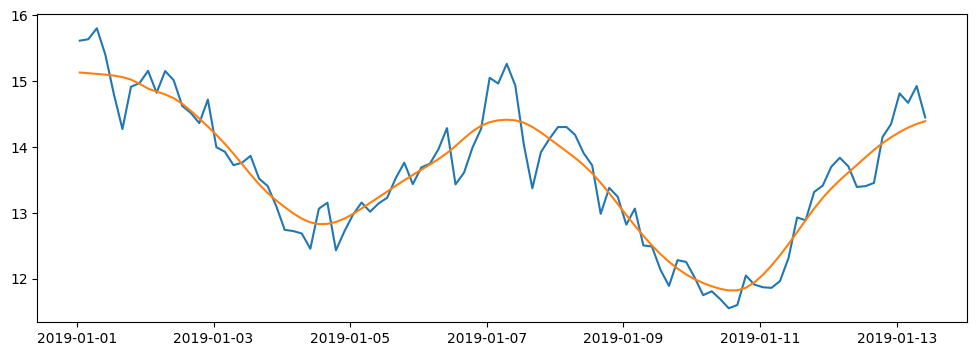

In [938]:
plt.figure(figsize=(12,4))
plt.plot((result.resid+ result.trend)[:100])
plt.plot((result2.trend)[:100])

Il n'y donc plus de saisonalité cette courbe correspond à une moyenne des températures sur une journée 

Fonction pour découper la database données en trois train / test / new data

In [939]:
def decoupe_data(data,div):
    data = data.reset_index(drop=True)
    mul = div - 1
    max = data.index.max()
    new_index = data.index.max() -400
    val = max / div 
    train_test_index = int(mul*val)
    return data.iloc[0:train_test_index],data.iloc[train_test_index:new_index],data.iloc[new_index:max]


## Forcasting en utilisant des méthodes vues en cours

### NaiveForcaster

En utilisant une database d'une des régions en l'occurence l'IDF


In [940]:

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series

def plot_ys(*args, **kwargs):
    # restore previous behaviour (jfb)
    nb_series=len(args)
    plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

8193 2331


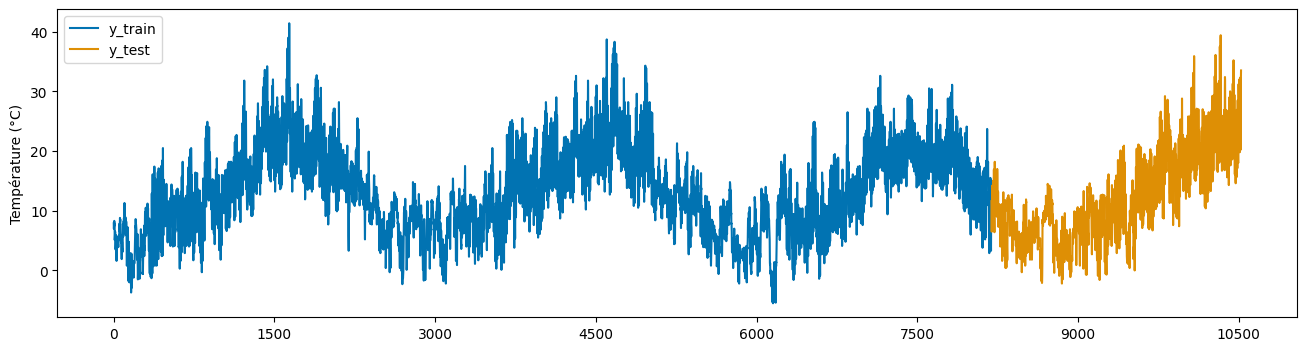

In [941]:
y = pd.Series(data=IledeFrance['Température (°C)']) #index=t[1:],
#y_train, y_test = temporal_train_test_split(y, test_size=2000)
y_train,y_test,new = decoupe_data(IledeFrance['Température (°C)'],4)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [942]:
fh = np.arange(1,len(y_test)+1) 


In [943]:
# Pour limiter le nombre de points, on ne prend que les 200 derniers
y_train = y_train[-4000:]


2890 13331118588099.15
2900 17002006315256.648
2910 11592277033129.826
2920 18547643253007.105
2930 17195210932475.49
la valeur la plus faible en loss correspond à une saisonalité de :  2910


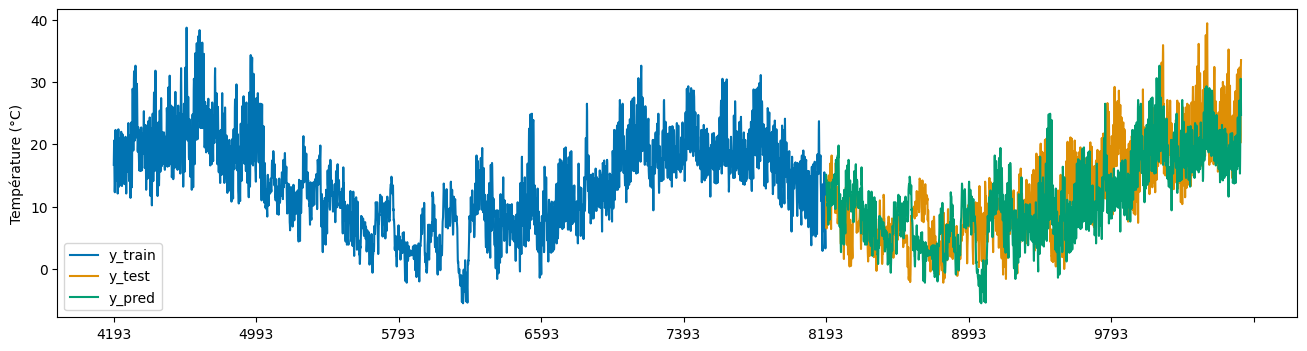

In [944]:
# using sktime 
res = []
val = [2890,2900,2910, 2920,2930]
from sktime.forecasting.naive import NaiveForecaster
for i in val:
    forecaster = NaiveForecaster(strategy="last",sp=i)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    res.append(smape_loss(y_pred, y_test))
    print(i,res[-1])
saisonalite = val[res.index(min(res))]

print("la valeur la plus faible en loss correspond à une saisonalité de : ",saisonalite)

forecaster = NaiveForecaster(strategy="last",sp=saisonalite)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
smape_loss(y_pred, y_test)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);


On peut voir que cette méthode copie simplement les données de la saison précédente sans aucune plus value. Le choix de la saisonalité est donc important c'est pour cela que nous avons fait une sélection de cette hyper paramètre. Dans ce cas les résultats pourraient être meilleurs mais il n'est pas intéréssant d'utiliser un modèle comme celui-ci pour la température car même si la température sera proche d'une année sur l'autre il y a beaucoup d'autres facteurs qui interviennent et modifient la valeur.

### Approches réduction - K Neighboor

17774824784131.82

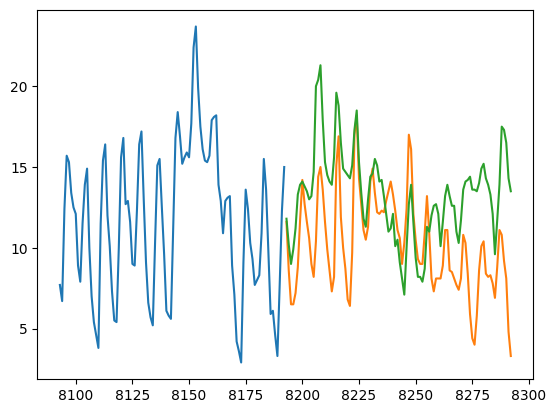

In [945]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(estimator=regressor, 
                                         window_length=10, strategy="direct")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plt.plot(y_train[-100:]) 
plt.plot(y_test[:100]) 
plt.plot(y_pred[:100])
smape_loss(y_test, y_pred)

### Exponential smoothing

29334822075749.63

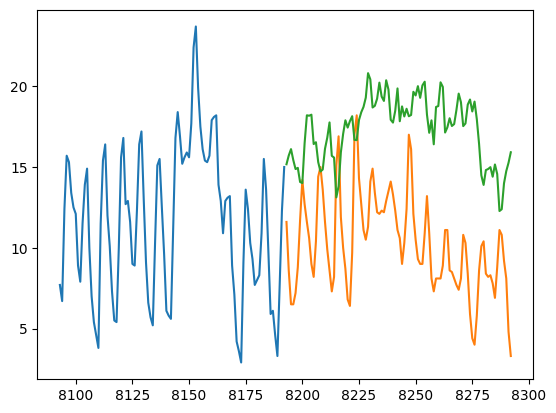

In [946]:

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="add", 
                                  sp=2000)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plt.plot(y_train[-100:]) 
plt.plot(y_test[:100]) 
plt.plot(y_pred[:100])
smape_loss(y_test, y_pred)

On observe qu'avec un exponential smoothing, nous avons de plus en plus de mal a être proche de la réalité. Les températures ont tendance à être plus hautes que la réalité et ce n'est pas ce que nous recherchons.

### Sarimax modèles

In [947]:
import warnings
warnings.filterwarnings("ignore")

In [948]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [949]:
perform_adf_test(IledeFrance['Température (°C)'])

ADF Statistic: -4.415856
p-value: 0.000278


On peut voir que la p-value est inférieure a 0.05 on peut donc conclure avec une haute confiance que notre série est stationnaire. On peut supposer que le résultat est le même pour les autres régions.

In [950]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

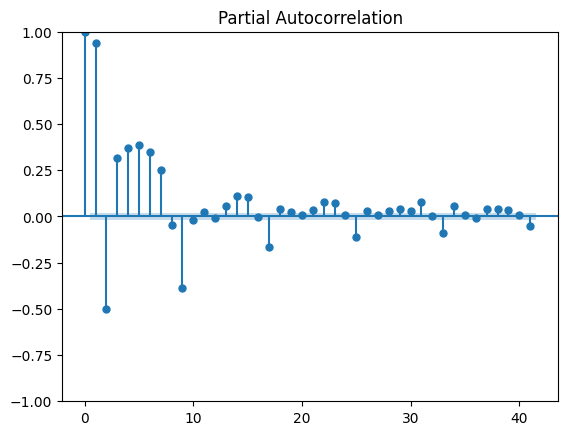

In [951]:
pacf_plot = plot_pacf(IledeFrance['Température (°C)'])

On peut voir qu'il y a beaucoup de point qui ont une influence directe sur la mesure à l'instant $t$. On va garder uniquement les 9 premiers points dans notre études pour ne pas faire trop complexe. De plus, 9 mesures correspondent à une journée, concrètement la température de la veille à la même heure est corrélée avec la température actuelle. Ce graphique induit un modèl AR(9).

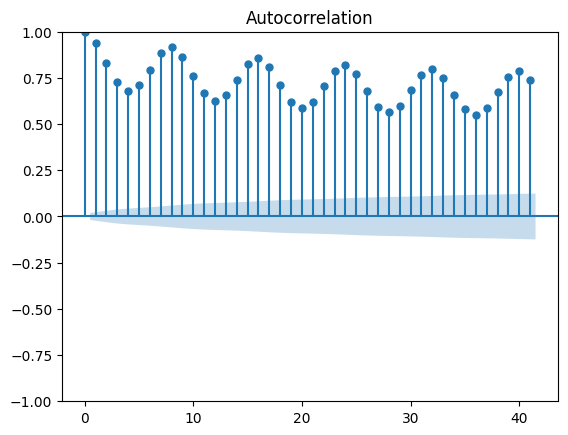

In [952]:
acf_plot = plot_acf(IledeFrance['Température (°C)'])

On peut voir que les 40 mesures qui précèdent une mesures ont une influence sur la température à l'instant $t$. Ce qui est logique même si on peut déduire que nous n'avons pas d'informations supplémentaires si on prend en compte les données au dela de 9 points.

## AR model


In [953]:
from statsmodels.tsa.arima.model import ARIMA


In [954]:
y_train,y_test,new = decoupe_data(IledeFrance['Température (°C)'],5)

In [955]:
# for p in [1,2,7,8,9]:
#     mod_AR = ARIMA(y_train, order=(p,0,0))
#     res = mod_AR.fit()
#     print("p={}, d={}, q={} --> AICc = {}".format(p,0,0, res.aicc))


Le AIC les plus petit est pour p=9, d=0, q=0 donc un modèle AR(9)

In [956]:
mod_AR = ARIMA(y_train, order=(9,0,0))
res = mod_AR.fit()


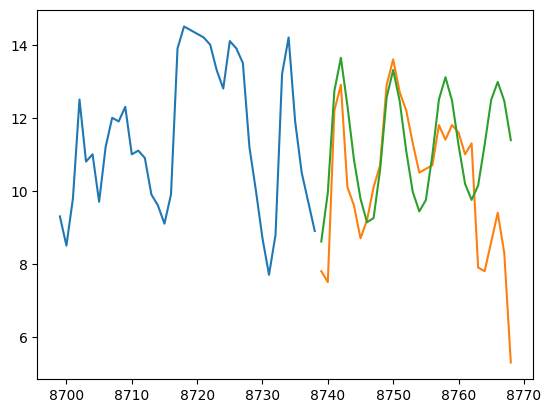

In [957]:
plt.plot(y_train[-40:])
plt.plot(y_test[:30])
plt.plot(res.forecast(30))

Les premières prédictions sont proches de la réalité, mais plus on s'éloigne plus il y a des erreurs, c'est la limite de ces modèles. On peut les utiliser à cours terme, cependant une autre limite est que si il y a un évènement météologique soudain il ne peuvent pas le prendre en compte car il n'ont pas de feature en plus. 

### ARMA model

On peut compléter le modèle en utilisant un modèle $moving$ $average$, il n'est pas intéréssant d'ultiliser ce type de modèle seul car il prédit très vite uniquement la moyenne même si dans notre cas aux vus du plot ACF on pourrait utiliser les erreurs d'au moins 40 données précédentes. Par soucis de temps de compilation, on va uniquement tester en utilisant jusqu'à 10 données précédentes.

In [958]:
# for q in [1,2,3,4,8,9,10]:
#     mod_ARMA = ARIMA(y_train, order=(9,0,q))
#     res = mod_ARMA.fit()
#     print("p={}, d={}, q={} --> AICc = {}".format(9,0,q, res.aicc))

On peut voir que le AIC le plus petit est pour le parametre du model MA le plus grand, il est possible que si on prenait un plus grand paramètre les résultats seraient meilleurs.

In [959]:
mod_ARMA = ARIMA(y_train, order=(9,0,10))
res = mod_AR.fit()

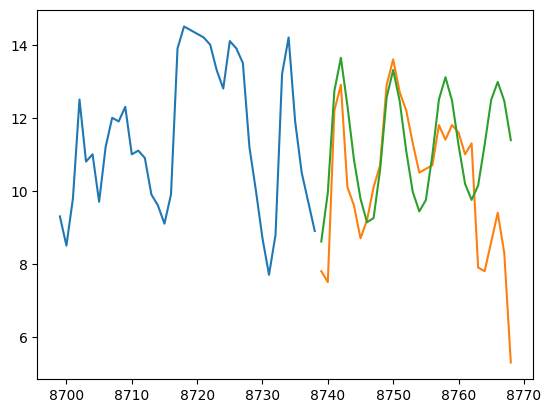

In [960]:
plt.plot(y_train[-40:])
plt.plot(y_test[:30])
plt.plot(res.forecast(30))

Le résultat reste le même, on peut voir que les premières prédictions sont proches des mesures mais les suivantes beaucoup moins.

### Avec la saisonalité et les features

On va maintenant prendre en compte la saisonalité ainsi que les features

Il y a plusieurs saisonalités possibles : une annuelle et une journalière. La recherche et l'entrainement d'un modèle avec la saisonalité annuelle est trop long, on ne va donc pas la faire. Cependant on va essayer de prédire une année en entrainant un modèle sur une periodicité journalière. On va ensuite garder les hyper paramètres trouvés pour entrainer un modèle avec une autre régions et voir si les paramètres dépendent d'une région ou sont généraux.

In [961]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


2909 obesrvations correspond au nombre d'observation sur un ans de la BDD IledeFrance

In [962]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

y = IledeFrance['Température (°C)']
x = IledeFrance[col]

y_train = y[:2909]
x_train = x[:2909]
y_test = y[2909:3000]
x_test = x[2909:3000]


In [963]:
perform_adf_test(y_train)

ADF Statistic: -2.757684
p-value: 0.064577


En prenant en compte que 1 ans notre serie n'est plus stationaire ce qui est logique

In [964]:
y_train_2 =  y_train.diff(1)
perform_adf_test(y_train_2.dropna())


ADF Statistic: -13.102835
p-value: 0.000000


Avec une differenciation elle devient stationnaire.

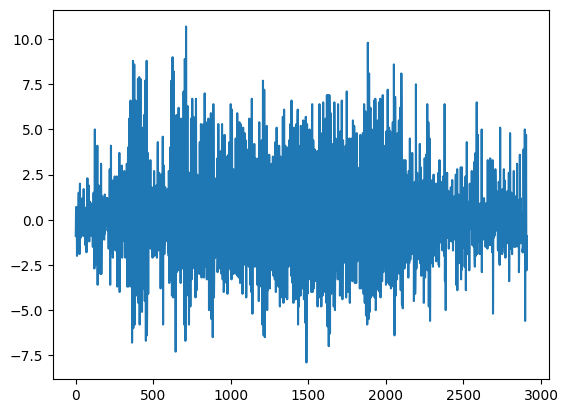

In [965]:
plt.plot(y_train_2)

Dans notre modèle il faudra donc indiquer qu'une differenciation est nécessaire 

Les cellules suivantes permettent de faire la selection des meilleurs paramètres pour notre model SARIMAX. On s'est limité à 0,1,2 pour tous les paramètres car sinon la recherche prenait trop de temps.

In [966]:
# import itertools



# p=d=q=range(0,2)

# pdq=list(itertools.product(p,d,q))
# seasonal_pdq=[(x[0],x[1],x[2],9) for x in list(itertools.product(p,d,q))]



In [967]:
# tab = []
# f = []
# s = []
# for pdq_params in pdq:
#     for seasonal_params in seasonal_pdq:
#         try:
#             model=SARIMAX(y_train,x_train,
#                           order=pdq_params,
#                           seasonal_order=seasonal_params
#                          )
#             result=model.fit()
#             # print("SARIMAX({}x{}12)-AIC:{}".format(pdq_params,
#             #                                        seasonal_params,
#             #                                        result.aicc
#             #                                       ))
#             print(pdq_params,seasonal_params,result.aic)
#             tab.append(result.aic)
#             f.append(pdq_params)
#             s.append(seasonal_params)
#         except:
#             continue




In [968]:
# min2 = tab.index(min(tab))
# pdq = f[min2]
# sais = s[min2]
# pdq,sais

In [969]:
# Pour saisonalité journalière
pdq = (1, 1, 1)
sais =(1, 0, 0, 9)

In [970]:
model=SARIMAX(y_train,x_train,
            order=pdq,
            seasonal_order=sais)
result=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14185D+00    |proj g|=  4.53717D+00

At iterate    5    f=  1.14041D+00    |proj g|=  6.93872D+00

At iterate   10    f=  1.13930D+00    |proj g|=  2.01860D+00

At iterate   15    f=  1.13585D+00    |proj g|=  7.62673D+00

At iterate   20    f=  1.13506D+00    |proj g|=  1.12093D-01

At iterate   25    f=  1.13447D+00    |proj g|=  2.91445D+00

At iterate   30    f=  1.11872D+00    |proj g|=  7.67576D+00

At iterate   35    f=  1.11560D+00    |proj g|=  2.21266D-01

At iterate   40    f=  1.10624D+00    |proj g|=  1.28319D+01

At iterate   45    f=  1.10499D+00    |proj g|=  6.12293D-01

At iterate   50    f=  1.10329D+00    |proj g|=  3.23989D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [971]:
predict=result.predict(start=len(y_train),
                    end=(len(y_train)+len(y_test)-1),
                    exog=x_test)


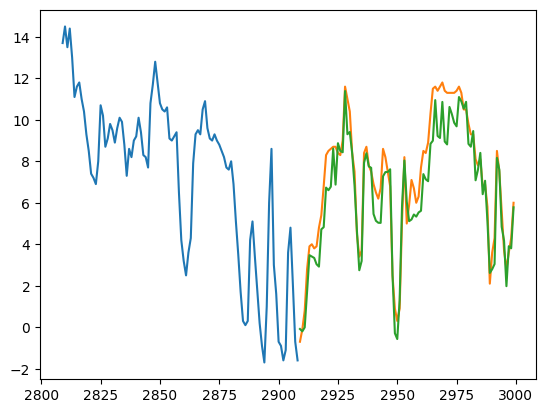

In [972]:
plt.plot(y_train[-100:])
plt.plot(y_test)
plt.plot(predict)

In [973]:
residuals = y_test - predict
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.1010817495181155


En introduisant un paramètre de saisonalité et les features on obtient des résultats vraiment excellents, les prédictions sont très proches des vrais valeurs.

Prédiction à plus grande échelle

In [974]:
y_test = y[2909:]
x_test = x[2909:]

predict=result.predict(start=len(y_train),
                    end=(len(y_train)+len(y_test)-1),
                    exog=x_test)

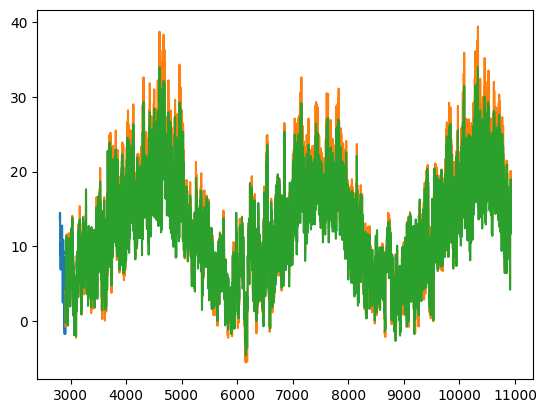

In [975]:
plt.plot(y_train[-100:])
plt.plot(y_test)
plt.plot(predict)

In [976]:
residuals = y_test - predict
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.5866431969993167


L'erreur reste très faible sur toute les données suivante c'est un modèle très (trop?) performant. Mais est ce qu'il est utile pour une autre région?

Utilisation d'un model identique sur une région complétement différente

In [977]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']

y = Terresaustralesetantarctiquesfrançaises['Température (°C)']
x = Terresaustralesetantarctiquesfrançaises[col]

y_train = y[:2910]
x_train = x[:2910]
y_test = y[2910:3000]
x_test = x[2910:3000]

In [978]:
model=SARIMAX(y_train,x_train,
            order=pdq,
            seasonal_order=sais)
result=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94592D+00    |proj g|=  2.31733D+01


 This problem is unconstrained.



At iterate    5    f=  1.94256D+00    |proj g|=  8.24604D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      9     27      1     0     0   1.872D-01   1.942D+00
  F =   1.9420829042621934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [979]:
predict=result.predict(start=len(y_train),
                    end=(len(y_train)+len(y_test)-1),
                    exog=x_test)

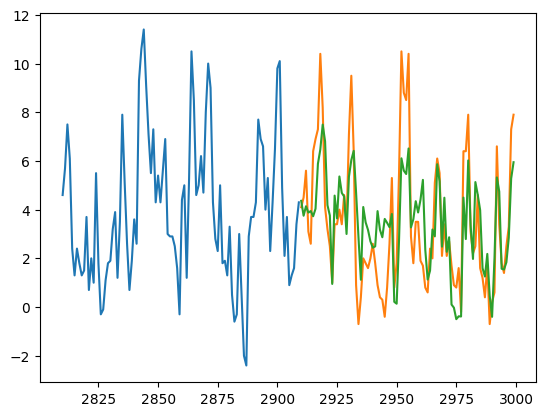

In [980]:
plt.plot(y_train[-100:])
plt.plot(y_test)
plt.plot(predict)

In [981]:
residuals = y_test - predict
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1.8672168079357203


Les prédicitions sont loin d'être mauvaises mais ne sont pas aussi précises que pour le modèle précédent. Il faut donc entrainer un modèle pour chaque région géographique. Cependant dans cet exemple les nous avons pris deux régions très éloignées. Il est possible que deux regions proches puisse utiliser les même hyper paramètres.

### Deep learning using RNN

Dans cette partie on va utiliser un RNN uniquement sur les données de température. Nous avons essayé de faire le travail sur les données avec les features mais nous nous sommes retrouvés avec une base de données vide et nous n'avons pas réussi à corriger le problème. 

In [982]:
from sklearn.preprocessing import MinMaxScaler

In [983]:
Terresaustralesetantarctiquesfrançaises.set_index('Date', inplace = True)


In [984]:
T = 10
HORIZON = 1

In [985]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période','Précipitations dans les 3 dernières heures']
valid_start_dt = '2021-07-01 00:00:00'
test_start_dt = '2022-01-01 00:00:00' 
train = Terresaustralesetantarctiquesfrançaises.copy()[Terresaustralesetantarctiquesfrançaises.index < valid_start_dt][['Température (°C)']]

scaler = MinMaxScaler()
train['Température (°C)'] = scaler.fit_transform(train)
# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['Température (°C)'].shift(-1)

for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['Température (°C)'].shift(T-t)
y_col = 'y_t+1'
X_cols = [  'temp_t-9',
            'temp_t-8',
            'temp_t-7',
            'temp_t-6',
            'temp_t-5',
             'temp_t-4',
             'temp_t-3',
             'temp_t-2',
             'temp_t-1',
             'temp_t']
train_shifted.columns = ['temp_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,temp_original,y_t+1,temp_t-9,temp_t-8,temp_t-7,temp_t-6,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
Date,,,,,,,,,,,,
2019-01-03 22:00:00,0.339844,0.484375,0.519531,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844
2019-01-04 04:00:00,0.484375,0.636719,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375
2019-01-04 10:00:00,0.636719,0.464844,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719
2019-01-04 16:00:00,0.464844,0.472656,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719,0.464844
2019-01-04 22:00:00,0.472656,0.511719,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719,0.464844,0.472656


In [986]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [987]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [988]:
train_shifted.head(3)

,temp_original,y_t+1,temp_t-9,temp_t-8,temp_t-7,temp_t-6,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t
Date,,,,,,,,,,,,
2019-01-03 22:00:00,0.339844,0.484375,0.519531,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844
2019-01-04 04:00:00,0.484375,0.636719,0.695312,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375
2019-01-04 10:00:00,0.636719,0.464844,0.574219,0.582031,0.835938,0.765625,0.675781,0.683594,0.421875,0.339844,0.484375,0.636719


In [989]:
import datetime as dt

# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = Terresaustralesetantarctiquesfrançaises.copy()[(Terresaustralesetantarctiquesfrançaises.index >=look_back_dt) & (Terresaustralesetantarctiquesfrançaises.index < test_start_dt)][['Température (°C)']]

# 2. Scale the series using the transformer fitted on the training set:
valid['Température (°C)'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['Température (°C)'].shift(-1)
for t in range(1, T+1):
    valid_shifted['temp_t-'+str(T-t)] = valid_shifted['Température (°C)'].shift(T-t)
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,Température (°C),y+1,temp_t-9,temp_t-8,temp_t-7,temp_t-6,temp_t-5,temp_t-4,temp_t-3,temp_t-2,temp_t-1,temp_t-0
Date,,,,,,,,,,,,
2021-07-02 23:00:00,0.527344,0.484375,0.328125,0.304688,0.265625,0.324219,0.253906,0.234375,0.324219,0.378906,0.445313,0.527344
2021-07-03 05:00:00,0.484375,0.363281,0.304688,0.265625,0.324219,0.253906,0.234375,0.324219,0.378906,0.445313,0.527344,0.484375
2021-07-03 11:00:00,0.363281,0.250000,0.265625,0.324219,0.253906,0.234375,0.324219,0.378906,0.445313,0.527344,0.484375,0.363281


In [990]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].to_numpy()
X_valid = valid_shifted[['temp_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [991]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [992]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,GRU ,RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

In [993]:
model=Sequential()

In [994]:
LATENT_DIM = 100 # number of units in the RNN layer
BATCH_SIZE = 64 # number of samples per mini-batch
EPOCHS = 200 # maximum number of times the training algorithm will cycle through all samples


In [995]:


model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dropout(0.2))
model.add(Dense(HORIZON))



In [996]:
model.compile(optimizer='RMSprop', loss='mse')

In [997]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [998]:

model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_46 (GRU)                (None, 100)               30900     
                                                                 
 dropout_36 (Dropout)        (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [999]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/200


2022-11-04 15:51:30.178633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-04 15:51:30.405370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-04 15:51:31.074548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.0217

2022-11-04 15:51:32.987403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-04 15:51:33.060176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 4s 42ms/step - loss: 0.0217 - val_loss: 0.0126
Epoch 2/200
47/47 [==============================] - 1s 15ms/step - loss: 0.0128 - val_loss: 0.0111
Epoch 3/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0118 - val_loss: 0.0110
Epoch 4/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 5/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 6/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 7/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 8/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0098 - val_loss: 0.0086
Epoch 9/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 10/200
47/47 [==============================] - 1s 14ms/step - loss: 0.0098 - val_loss: 0.0084
Epoch 11/20

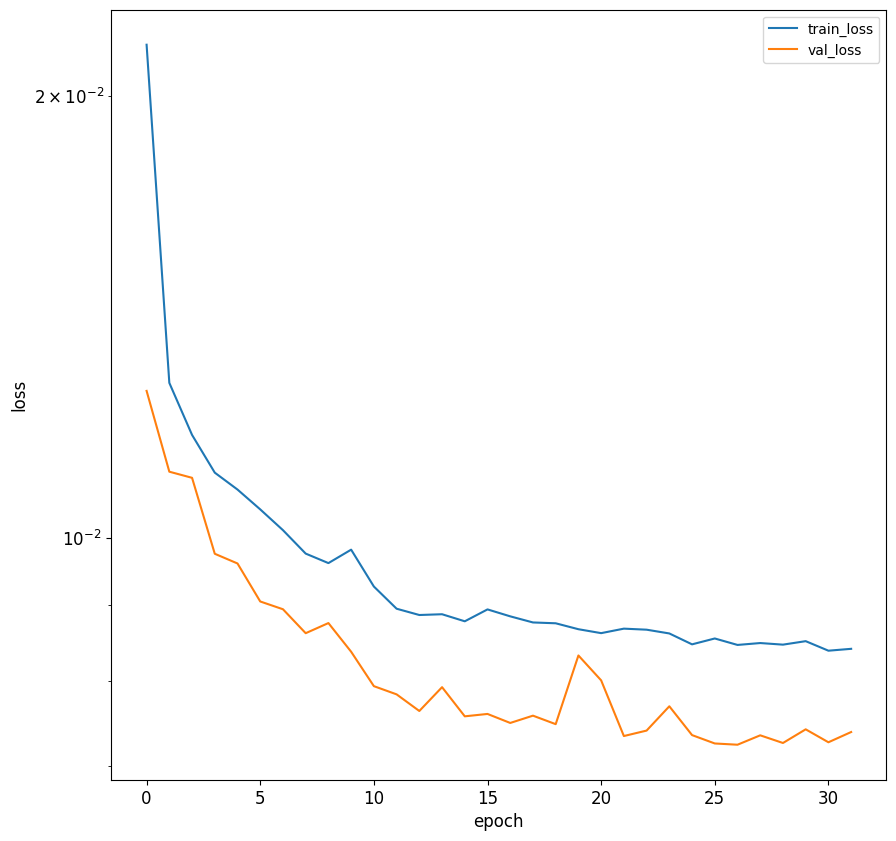

In [1000]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()


In [1001]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = Terresaustralesetantarctiquesfrançaises.copy()[test_start_dt:][['Température (°C)']]

# 2. Scale the data
test['Température (°C)'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['Température (°C)'].shift(-1)
for t in range(1, T+1):
    test_shifted['temp_t-'+str(T-t)] = test_shifted['Température (°C)'].shift(T-t)

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].to_numpy()
X_test = test_shifted[['temp_t-'+str(T-t) for t in range(1, T+1)]].to_numpy()
X_test = X_test.reshape(X_test.shape[0], T, 1)



In [1002]:
predictions = model.predict(X_test)
predictions

2022-11-04 15:51:54.376422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-04 15:51:54.424771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 1s 8ms/step


array([[0.3310422 ],
       [0.4415872 ],
       [0.3672538 ],
       ...,
       [0.29785138],
       [0.25706375],
       [0.24139474]], dtype=float32)

In [1003]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2022-01-03 16:00:00,t+1,3.274680,3.0
1,2022-01-03 22:00:00,t+1,6.104633,4.6
2,2022-01-04 04:00:00,t+1,4.201698,7.6
3,2022-01-04 10:00:00,t+1,5.167115,6.1
4,2022-01-04 16:00:00,t+1,6.342847,3.3


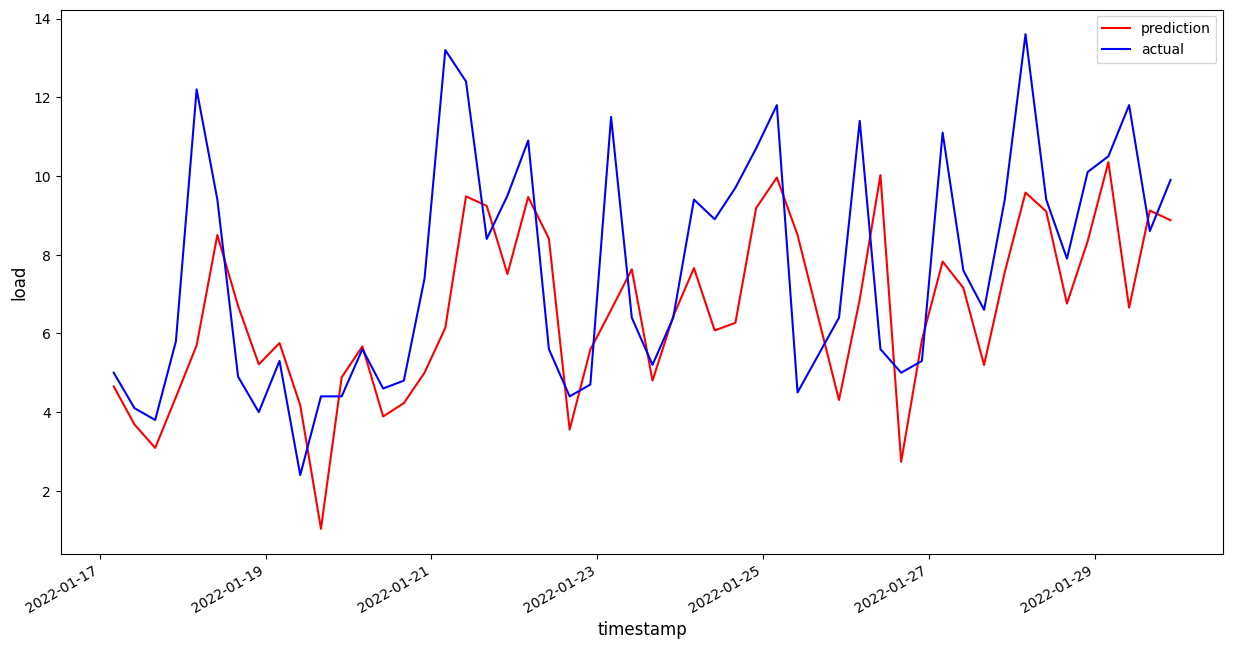

In [1004]:
eval_df[eval_df.timestamp<'2022-01-30'][eval_df.timestamp>'2022-01-17'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [1005]:
residuals = eval_df['actual'] - eval_df['prediction']
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2.2512801609378736


On voit que les prédiction sont décalées d'une période dans le temps notre modèle ne marche donc pas. On pourrait penser à rendre notre modèle plus profond, ce que nous avons fait mais le résultat a empiré. Soit nous avons fait des erreurs en préparant les données soit notre modèle ne marche pas.

Nous pensons qu'en entrainant un modèle avec les features nous aurions eu des résultats comme avec le modèle SARIMAX.

## Première analyse 

Jusque la, nous avons vu que sans les features nous ne pouvions pas prédire correctement la température. Mais du coup un problème se pose, nos features sont des observations que l'on ne peut pas prédire avec certitude. Donc si on veut pouvoir prédire correctement la température il faut prédire les features d'abord. Le problème est qu'une prédiction n'est jamais parfaite, donc prédire à partir d'une prédiction c'est multiplier l'erreur. Une donnée unique n'est pas suffisante à elle seule pour produire des prévisions.

### Cas d'étude, les prédictions sont elles susceptibles de prévoir des événements météorologiques important tel que des sécheresses ?

Nous essaierons ici de prédire pour une région donnée, extensible à toutes nos régions, les températures ainsi que le taux de précipitations dans les 3 dernières heures. Si nous observons à la fois de fortes températures et un niveau de précipitation faible, alors nous pourrons estimer qu'un risque de sécheresse est élevé. L'objectif est d'améliorer la confiance que nous pouvons accorder à nos prédictions si plusieurs prédictions sur différentes données nous orientent tous vers la même conclusion car nous estimons que la température seule ne suffirait pas a établir une alerte. Nous utiliserons ici SARIMAX et notre région de test sera l'Ile de France.

In [1006]:
IledeFrance

,Date,Température (°C),Pression au niveau mer,Vitesse du vent moyen 10 mn,Humidité,Pression station,Rafales sur une période,Précipitations dans les 3 dernières heures
0,2019-01-01 01:00:00,7.9,103630.0,2.6,84.0,102510.0,5.1,0.0
1,2019-01-01 04:00:00,7.0,103610.0,2.3,91.0,102480.0,4.1,-0.1
2,2019-01-01 07:00:00,7.1,103500.0,2.0,89.0,102380.0,3.9,0.0
3,2019-01-01 10:00:00,7.8,103510.0,2.3,84.0,102390.0,5.0,0.0
4,2019-01-01 13:00:00,8.1,103470.0,3.4,77.0,102350.0,7.8,0.0
...,...,...,...,...,...,...,...,...
10920,2022-10-01 11:00:00,16.5,101160.0,4.8,87.0,100100.0,9.1,0.0
10921,2022-10-01 14:00:00,20.1,101310.0,6.0,64.0,100260.0,12.7,0.0
10922,2022-10-01 17:00:00,19.8,101460.0,5.4,57.0,100410.0,13.0,-0.1
10923,2022-10-01 20:00:00,17.8,101720.0,4.3,61.0,100660.0,9.9,0.0


In [1007]:
col = ['Pression au niveau mer','Vitesse du vent moyen 10 mn','Humidité','Pression station','Rafales sur une période']

y_temp = IledeFrance['Température (°C)']
y_pluie= IledeFrance['Précipitations dans les 3 dernières heures']
x = IledeFrance[col]

y_temp_train = y_temp[:2909]
y_pluie_train = y_pluie[:2909]
x_train = x[:2909]
y_temp_test = y_temp[2909:3000]
y_pluie_test = y_pluie[2909:3000]
x_test = x[2909:3000]

y_pluie_test

2909    0.0
2910    0.0
2911    0.0
2912    0.0
2913    0.0
       ... 
2995    0.0
2996    0.0
2997    0.0
2998    0.0
2999    0.0
Name: Précipitations dans les 3 dernières heures, Length: 91, dtype: float64

In [1008]:
perform_adf_test(y_temp_train)
perform_adf_test(y_pluie_train)

ADF Statistic: -2.757684
p-value: 0.064577
ADF Statistic: -8.980038
p-value: 0.000000


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39866D+00    |proj g|=  3.06574D+00


 This problem is unconstrained.



At iterate    5    f=  1.39661D+00    |proj g|=  2.13062D+00

At iterate   10    f=  1.39651D+00    |proj g|=  2.29084D+00

At iterate   15    f=  1.39519D+00    |proj g|=  6.37806D-01

At iterate   20    f=  1.39500D+00    |proj g|=  2.80889D-01

At iterate   25    f=  1.39479D+00    |proj g|=  4.02319D+00

At iterate   30    f=  1.39278D+00    |proj g|=  6.32371D-01

At iterate   35    f=  1.39276D+00    |proj g|=  5.44291D-01

At iterate   40    f=  1.39201D+00    |proj g|=  3.03599D+00

At iterate   45    f=  1.39174D+00    |proj g|=  9.45637D-01

At iterate   50    f=  1.39083D+00    |proj g|=  4.17247D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

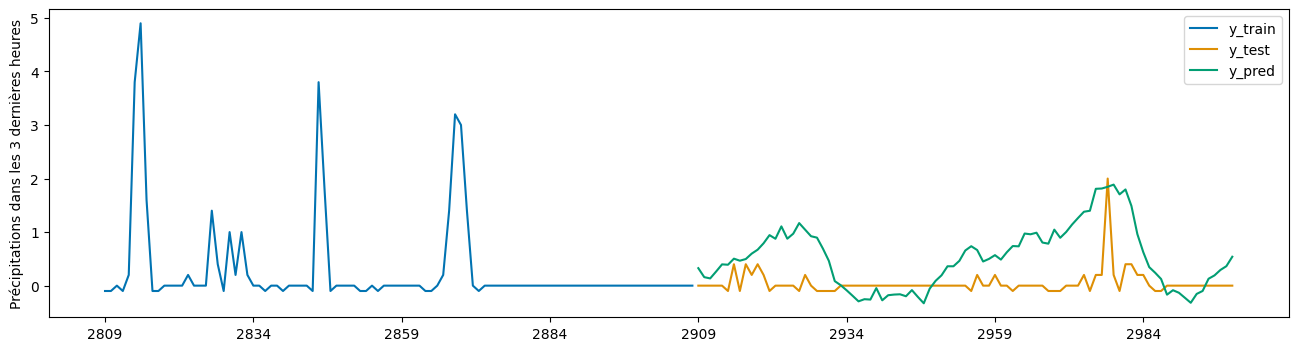

In [1009]:
model_pluie=SARIMAX(y_pluie_train,x_train,
            order=pdq,
            seasonal_order=sais)
result_pluie=model_pluie.fit()
predict_pluie=result_pluie.predict(start=len(y_pluie_train),
                    end=(len(y_pluie_train)+len(y_pluie_test)-1),
                    exog=x_test)

plot_ys(y_pluie_train[-100:], y_pluie_test, predict_pluie, labels=["y_train", "y_test", "y_pred"]);
residuals = y_pluie_test - predict_pluie
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14350D+00    |proj g|=  4.69718D+00

At iterate    5    f=  1.14214D+00    |proj g|=  6.86163D+00

At iterate   10    f=  1.14084D+00    |proj g|=  2.89266D+00

At iterate   15    f=  1.13793D+00    |proj g|=  7.80312D+00

At iterate   20    f=  1.13686D+00    |proj g|=  4.44733D-01

At iterate   25    f=  1.13154D+00    |proj g|=  9.33228D+00

At iterate   30    f=  1.11823D+00    |proj g|=  1.07289D+00

At iterate   35    f=  1.11717D+00    |proj g|=  3.16532D+00

At iterate   40    f=  1.10951D+00    |proj g|=  1.64240D+01

At iterate   45    f=  1.10677D+00    |proj g|=  1.60845D+00

At iterate   50    f=  1.10187D+00    |proj g|=  9.96494D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

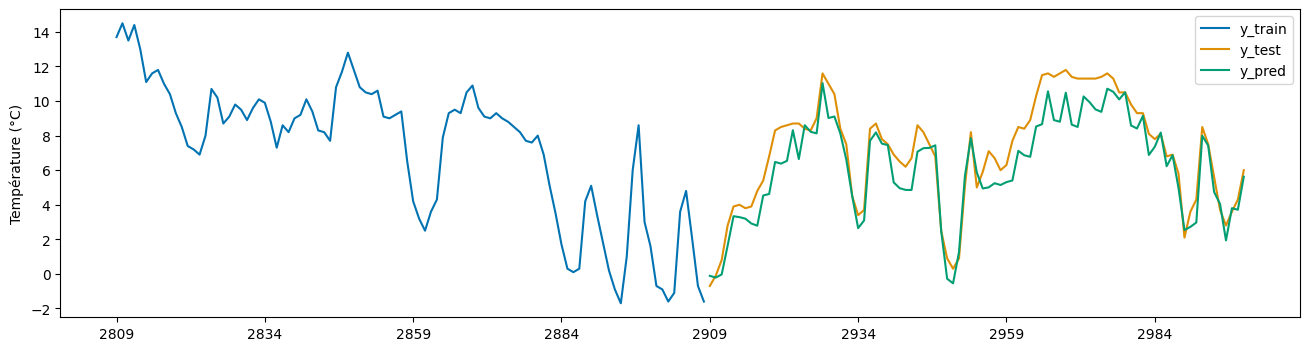

In [1010]:
model_temp=SARIMAX(y_temp_train,x_train,
            order=pdq,
            seasonal_order=sais)
result_temp=model_temp.fit()
predict_temp=result_temp.predict(start=len(y_temp_train),
                    end=(len(y_temp_train)+len(y_temp_test)-1),
                    exog=x_test)

plot_ys(y_temp_train[-100:], y_temp_test, predict_temp, labels=["y_train", "y_test", "y_pred"]);

residuals = y_temp_test - predict_temp
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

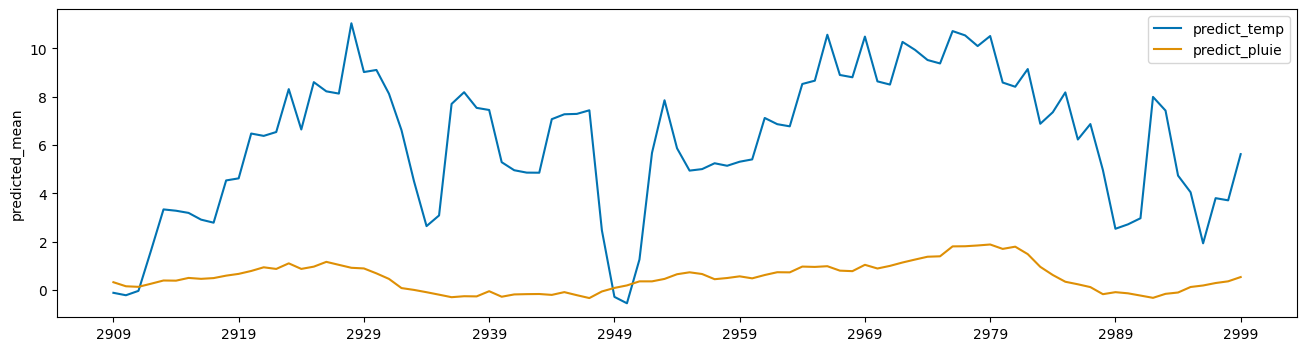

In [1011]:
plot_ys(predict_temp, predict_pluie, labels=["predict_temp", "predict_pluie"]);

On peut observer a plusieurs reprises que lorsque la température prédite augmente, les risques de pluie diminuent aussi, ce qui renforce l'idée que cette démarche est la bonne si nous voulons prévoir d'éventuels événements météorologiques. Biensûr, cela reste encore vague ici, mais un développement plus poussé de cette idée, c'est à dire des meilleurs prédictions sur des dizaines de features, pourraient amener à un modèle de détéction d'événements utile performant. En revanche, ce système ne fonctionne qu'avec SARIMAX et donc des données de test permettant la prédiction. En effet, dans le cadre d'une vraie prédiction comme avec le type ARMA par exemple, comme nous l'avons vu précédemment, les résultats seraient moins bons.

### Deuxième cas d'étude, prédiction from prédiction

Dans ce cas nous allons essayer de prédire la température en fonction de l'humidité. Nous devons donc construire 2 modèles un de type ARMA pour prédire l'humitidité et un SARIMAX pour prédire la température en fonction de l'humidité.

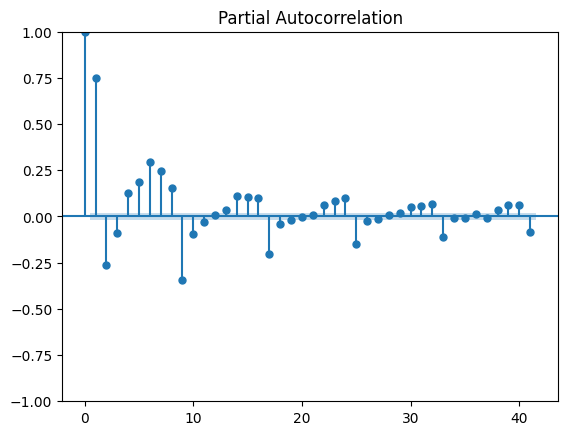

In [1012]:
pacf_plot = plot_pacf(Corse['Humidité'])

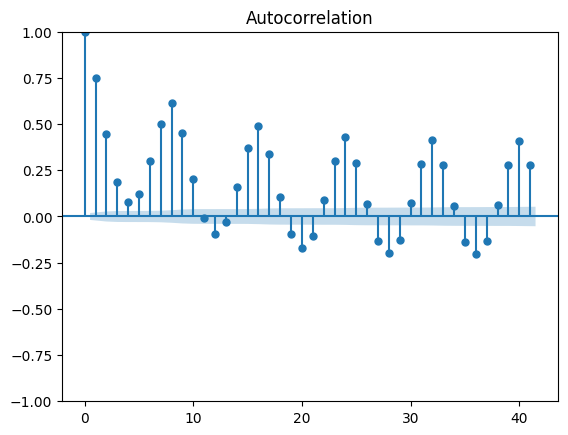

In [1013]:
pacf_plot = plot_acf(Corse['Humidité'])

In [1014]:
perform_adf_test(Corse['Humidité'])

ADF Statistic: -10.580318
p-value: 0.000000


Pas besoin de différencition

In [1015]:

y_temp = Corse['Température (°C)']
y_raf= Corse['Humidité']

y_temp_train = y_temp[:2850]
y_raf_train = y_raf[:2850]
y_temp_test = y_temp[2850:3000]
y_raf_test = y_raf[2850:3000]




In [1016]:
mod_ARMA_raf = ARIMA(y_raf_train, order=(10,0,10))
res = mod_ARMA_raf.fit()

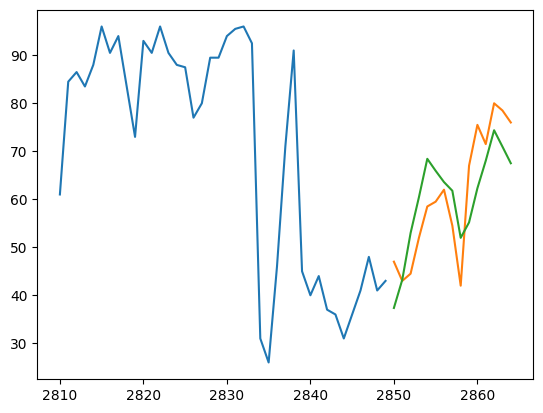

In [1017]:
plt.plot(y_raf_train[-40:])
plt.plot(y_raf_test[:15])
plt.plot(res.forecast(15))

Les prédictions semblent proches des mesures uniquement au début. On va donc essayer de prédire la température avec les 9 premières valeurs pour connaitre la température du lendemain.

In [1018]:
mod_SARIMAX_temp = SARIMAX(y_temp_train,y_raf_train, order=(8,0,10),seasonal_order=(0,0,0,0))
res2 = mod_SARIMAX_temp.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37290D+00    |proj g|=  2.33826D+00


 This problem is unconstrained.



At iterate    5    f=  1.94815D+00    |proj g|=  3.87913D-01

At iterate   10    f=  1.56872D+00    |proj g|=  7.51382D-01

At iterate   15    f=  1.50177D+00    |proj g|=  3.07164D-01

At iterate   20    f=  1.49081D+00    |proj g|=  6.92924D-02

At iterate   25    f=  1.48830D+00    |proj g|=  2.97816D-02

At iterate   30    f=  1.48530D+00    |proj g|=  3.31653D-02

At iterate   35    f=  1.48096D+00    |proj g|=  5.64652D-02

At iterate   40    f=  1.47949D+00    |proj g|=  6.25743D-02

At iterate   45    f=  1.47583D+00    |proj g|=  6.23530D-02

At iterate   50    f=  1.47342D+00    |proj g|=  9.87907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1019]:
predict=res2.predict(start=len(y_temp_train),
                    end=(len(y_temp_train)+len(res.forecast(9))-1),
                    exog=res.forecast(9))


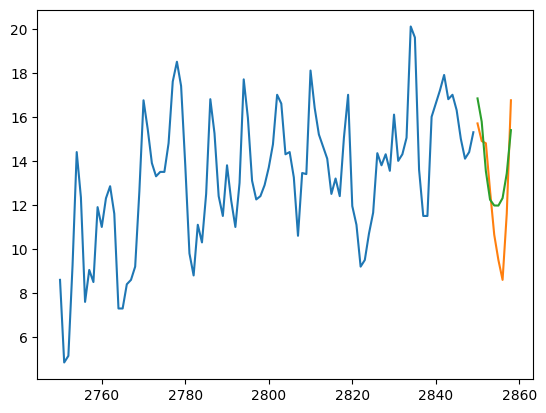

In [1020]:
plt.plot(y_temp_train[-100:])
plt.plot(y_temp_test[:9])
plt.plot(predict)

Le résultat n'est pas très convaincant. Si on faisait la même chose avec plus de features on pourrait soit avoir de meilleurs résultats car nous aurions des modèles qui prédisent correctement les features soit des prédictions moins bonnes car on aurait multiplié les erreurs.

# Conclusion

La température dépend de beaucoup de choses. La distance au soleil, l'épaisseur de l'atomshère que le rayon doit traverser... si la température ne dependait que de ça, ça serait facile de la prédire car on connait très bien la distance au soleil à chaque instant et l'épaisseur de l'atmosphère on en a une bonne estimation tout autour de la terre (exemple en Austalie elle est plus fine). Cependant il y a d'autre facteurs qui la font évoluer tels que le vent, les nuages ... ces phénomènes ne sont pas aléatoires, cependant ils dépendent de tellement de paramètres que il est très difficile de les prédire. On appelle cela l'effet papillon.

Avec cette base de données on ne peut prédire correctement des données futures car nos features sont des observations, il faudrait alors anticiper ces features. On peut essayer de prédire ces features mais on sait que les données météorologiques sont soumises à l'effet papillon et donc très aléatoires. Cependant à cours terme, il est possible d'avoir quelques estimations sur ces features et donc prédire la température de manière imprécise car se ne sont que des estimations et nous sommes limités à un futur proche. Il y a certains cas où on pourrait prédire plus loin. Par exemple lorsqu'une région va être sous un anti cyclone (phénomène que l'on prédit plutôt bien), on sera au courant qu'il n'y aura pas de vent, pas de pluie, pression constante, etc... on pourra donc prédire un plus grand horizon les températures.

D'autre part, nous observons que nos features sont très utiles pour la prédiction de la température car les modèles utilisant les features sont beaucoup plus précis que les autres (cf ARMA vs SARIMAX).